# Spitfire Example: custom tabulation of a flamelet model for coal combustion

This example showcases a flamelet library built with manual loops over the tabulation dimensions. We build a four-dimensional table of states over the mixture fraction, scalar dissipation rate (stoichiometric value), heat transfer coefficient, and fraction of volatiles and char in the fuel stream. The heat transfer dimension is expanded in a quasisteady manner, with steady states calcalated at each heat transfer coefficient (or, at each enthalpy defect), as an alternative to transient heat loss calculations in the provided `build_nonadiabatic_defect_transient_slfm_library` method.

Here we manually loop over table dimensions and use the `Flamelet` class directly instead of the higher-level convenience methods provided in the `spitfire.chemistry.tabulation` module. While the tabulation methods are much more convenient, this provides a finer level of control and customizability for tabulation techniques not currently wrapped in a high-level interface.

In [1]:
import numpy as np  # ............................................... for lots of things...
import matplotlib.pyplot as plt  # .................................. for visualization
import pickle  # .................................................... for loading the fuel stream data
from time import perf_counter  # .................................... for timing the tabulation solves
from spitfire.chemistry.mechanism import ChemicalMechanismSpec  # ... for mechanism data and streams
from spitfire.chemistry.flamelet import Flamelet  # ................. for flamelet solvers
from spitfire.chemistry.library import Dimension, Library  # ........ for structured tables
import spitfire.chemistry.analysis as sca  # ........................ for post-processing quantities on libraries

First we define a helper function for mixing char and volatiles and load some stream data for later use.

In [2]:
def get_fuel_stream(coal_fuels, alpha, mechanism, pressure):
    """
    Fuel streams representative of coal combustion, spanning char to volatiles, with volatiles fraction alpha.
    Personal communication with Josh McConnell, University of Utah, 2018.
    """
    volatiles = mechanism.stream('TPY', (coal_fuels['volatiles']['T'], pressure, coal_fuels['volatiles']['Y']))
    char = mechanism.stream('TPY', (coal_fuels['char']['T'], pressure, coal_fuels['char']['Y']))
    return mechanism.mix_streams([(volatiles, alpha), (char, 1. - alpha)], 'mass', 'HP')

with open('coalflamelet_bcs.pkl', 'rb') as bcs_src:
    coal_fuels = pickle.load(bcs_src)

Next we load up a wrapper of the GRI-3.0 methane combustion mechanism and make an air stream.

In [3]:
mechanism = ChemicalMechanismSpec(cantera_xml='methane-gri30.xml', group_name='gri30_mix')

pressure = 101325.

oxy = mechanism.stream(stp_air=True)
oxy.TP = 350., pressure

Next we specify the table dimensions for the char/volatiles fraction, dissipation rate, heat transfer coefficient, and mixture fraction. From the set of values of each variable we make a `Library` object. Then for each property to be tabulated we set up an empty dataset in the library to fill later as we perform continuation across each library dimension.

In [16]:
mixfrac_vec = np.linspace(0., 1., 128)
alpha_vec = np.array([0.0, 0.1, 0.3, 0.5, 0.7])
chist_vec = np.logspace(-1., 3., 8)
h_vec = np.hstack([0., np.logspace(-3, 1, 24)])

zdim = Dimension('mixture_fraction', mixfrac_vec)
xdim = Dimension('dissipation_rate_stoich', chist_vec)
hdim = Dimension('heat_transfer_coefficient', h_vec)
adim = Dimension('alpha', alpha_vec)

l = Library(adim, hdim, xdim, zdim)

for q in ['temperature', 'pressure'] + ['mass fraction ' + s for s in mechanism.species_names]:
    l[q] = l.get_empty_dataset()

Now we make a dictionary of specifications for the flamelet. This will be used as `**flamelet_specs` as the argument list for constructing a `Flamelet` instance. It is easier to make a dictionary of these arguments because we will be changing only one or two during the continuation process.

In [17]:
particle_temperature = 350.

flamelet_specs = {'mech_spec': mechanism,
                  'pressure': pressure,
                  'initial_condition': 'unreacted',
                  'oxy_stream': oxy,
                  'fuel_stream': get_fuel_stream(coal_fuels, 0., mechanism, pressure),
                  'grid': mixfrac_vec,
                  'include_enthalpy_flux': True,
                  'include_variable_cp': True,
                  'heat_transfer': 'nonadiabatic',
                  'convection_temperature': particle_temperature,
                  'convection_coefficient': 0.,
                  'radiation_temperature': particle_temperature,
                  'radiative_emissivity': 0.}

Now we enter into the loops. In continuation calculations it is critical to get the best initial guess, as this determines convergence rates and often the solution that is ultimately computed. We treat different values of alpha (the char/volatiles fraction) as separate problems entirely, not using the solution from one value to inform the next, as they the chemistry is so different between them.

For each alpha, then, we build a three-dimensional library over the dissipation rate, heat transfer coefficient, and mixture fraction. Note that with a bit of work (mostly just dealing with the fact that cantera gas objects cannot be pickled), each three-dimensional table could be generated in parallel with the `multiprocessing` module. A similar approach to parallelization is taken in the `build_nonadiabatic_defect_transient_slfm_library` method in Spitfire. Work to facilitate the extensibility of this sort of paralellization with Spitfire is under development. Another option is to write a script that saves off a three-dimensional library for each value of alpha, run a separate interpreter for each value, and then combine the libraries into the four-dimensional one of interest. So there are several valid options if parallelization is of interest.

In building the three-dimensional library, we first iterate over serial calculations in the dissipation rate direction with zero heat loss (adiabatic flamelets), where each prior solution provides an excellent initial guess for the next dissipation rate. From this line of solutions, then, we have even more parallel work in the heat loss dimension, which may be solved for each dissipation rate independently of the others. Again, each extension of the heat loss dimension is treated serially, using the prior solution as the initial guess.

Here we do not exploit the available parallelism in any way to keep things simple, but factors of ten speedup could be rather easily obtained with a bit of extra work for either Python-based multiprocessing or simply running multiple scripts and combining after the fact.

We leverage the general `compute_steady_state` method and the more specific `steady_solve_psitc` solver on the `Flamelet` instance to compute solutions to the flamelet equations. The general method attempts to solve the system in several ways, using aggressive solvers first and several more conservative solvers as prior ones fail. This provides the best combination of speed and robustness that no single solver is capable of providing. However, the flamelet equations are very complex and certain situations call for particular solvers. In this case we show how one can use a specific solver to compute the solution for only the first two nonzero dissipation rates, which are typically among the hardest calculations, and then use the general method afterwards.

In [18]:
cput000 = perf_counter()
for ia, alpha in enumerate(alpha_vec):
    print(f'Running alpha = {alpha:4.2f} ...')
    flamelet_specs.update({'fuel_stream': get_fuel_stream(coal_fuels, alpha, mechanism, pressure)})
    
    adiabatic_solutions = list()
    cput00 = perf_counter()
    for ichi, chist in enumerate(chist_vec):
        flamelet_specs.update({'stoich_dissipation_rate': chist})
        flamelet_specs.update({'initial_condition': 'equilibrium' if ichi == 0 else f.current_interior_state})
        f = Flamelet(**flamelet_specs)
        if ichi < 2:
            f.steady_solve_psitc(max_iterations=400, verbose=False)
        else:
            f.compute_steady_state()
        adiabatic_solutions.append(f.current_interior_state)
    cput1 = perf_counter()
    print(f'Converged adiabatic solutions in {cput1-cput00:6.2f} s {"":24} | total cpu time is {cput1 - cput000:6.2f} s')
    
    for ichi, chist in enumerate(chist_vec):
        flamelet_specs.update({'stoich_dissipation_rate': chist})
        cput0 = perf_counter()
        for ih, h in enumerate(h_vec):
            flamelet_specs.update({'convection_coefficient': h})
            flamelet_specs.update({'initial_condition': adiabatic_solutions[ichi] if ih == 0 else f.current_interior_state})
            f = Flamelet(**flamelet_specs)
            output = f.steady_solve_psitc(max_iterations=400, verbose=False)[0]
    
            for quantity in output.props:
                l[quantity][ia, ih, ichi, :] = output[quantity].ravel()
        cput1 = perf_counter()
        print(f'{"":9} heat loss solutions for chi_st = {chist:7.2e} Hz in {cput1-cput0:6.2f} s | {"":14} is {cput1 - cput000:6.2f} s')
    
    cput1 = perf_counter()
    print(f'Completed alpha = {alpha:4.2f} in {cput1-cput00:6.2f} s')
    print('-' * 95)

Running alpha = 0.00 ...
Converged adiabatic solutions in   4.17 s                          | total cpu time is   4.17 s
          heat loss solutions for chi_st = 1.00e-01 Hz in  12.06 s |                is  16.24 s
          heat loss solutions for chi_st = 3.73e-01 Hz in   4.18 s |                is  20.41 s
          heat loss solutions for chi_st = 1.39e+00 Hz in   3.50 s |                is  23.91 s
          heat loss solutions for chi_st = 5.18e+00 Hz in   3.35 s |                is  27.26 s
          heat loss solutions for chi_st = 1.93e+01 Hz in   3.36 s |                is  30.62 s
          heat loss solutions for chi_st = 7.20e+01 Hz in   3.35 s |                is  33.98 s
          heat loss solutions for chi_st = 2.68e+02 Hz in   3.38 s |                is  37.36 s
          heat loss solutions for chi_st = 1.00e+03 Hz in   3.36 s |                is  40.72 s
Completed alpha = 0.00 in  40.72 s
----------------------------------------------------------------------------

### Saving a library file for later use
Saving a library file to disk to be reloaded later is straightforward.

The rest of the notebook consists of some visualizations of the library data.

In [19]:
l.save_to_file('coal_library.pkl')
library = Library.load_from_file('coal_library.pkl')

In [20]:
z_dim = library.dim('mixture_fraction')
x_dim = library.dim('dissipation_rate_stoich')
h_dim = library.dim('heat_transfer_coefficient')
a_dim = library.dim('alpha')

adiabatic equilibrium temperatures for various mixtures of volatiles and char


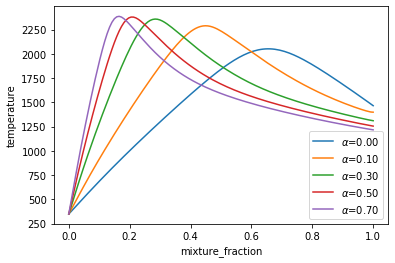

In [21]:
for ia, a in enumerate(a_dim.values):
    plt.plot(z_dim.values, library['temperature'][ia, 0, 0, :], label='$\\' + a_dim.name + '$' + f'={a:.2f}')
plt.legend(loc='best')
plt.xlabel(z_dim.name)
plt.ylabel('temperature')
print('adiabatic equilibrium temperatures for various mixtures of volatiles and char')
plt.show()

adiabatic temperatures for various mixtures of volatiles and char, at finite dissipation rate


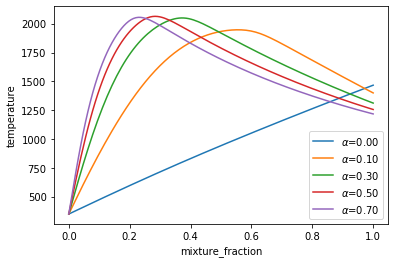

In [22]:
for ia, a in enumerate(a_dim.values):
    plt.plot(z_dim.values, library['temperature'][ia, 0, 6, :], label='$\\' + a_dim.name + '$' + f'={a:.2f}')
plt.legend(loc='best')
plt.xlabel(z_dim.name)
plt.ylabel('temperature')
print('adiabatic temperatures for various mixtures of volatiles and char, at finite dissipation rate')
plt.show()

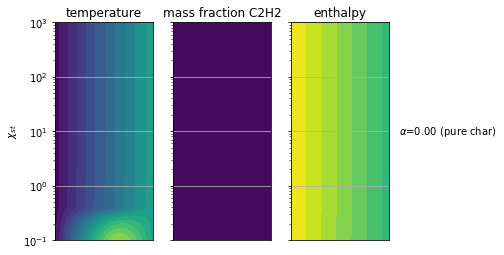

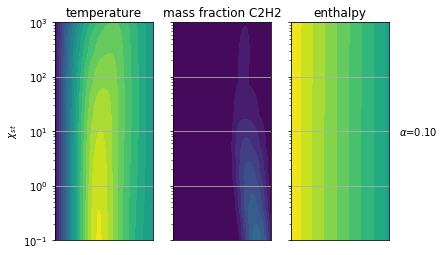

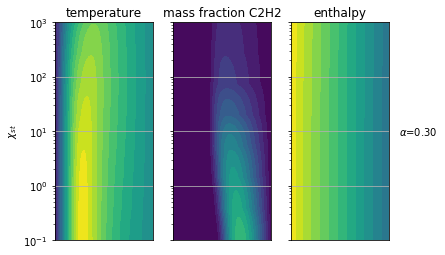

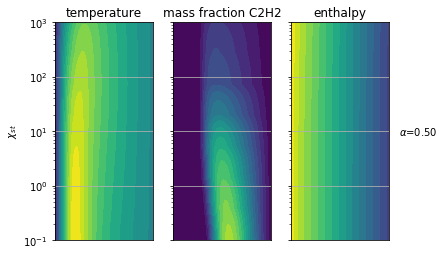

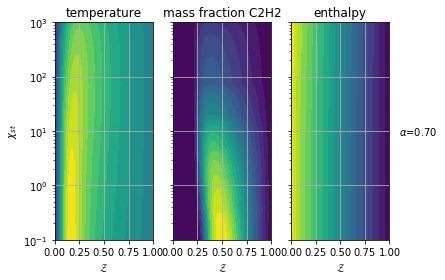

In [23]:
library = sca.compute_specific_enthalpy(mechanism, library)

T_max = np.max(library['temperature'])
C2H2_max = np.max(library['mass fraction C2H2'])
h_min = np.min(library['enthalpy'])
h_max = np.max(library['enthalpy'])

key1, key2, key3 = 'temperature', 'mass fraction C2H2', 'enthalpy'
alpha_indices = list(range(a_dim.npts))

ih = 0

for i, ig in enumerate(alpha_indices):
    fig, axarray = plt.subplots(1, 3, sharey=True, sharex=True)
    axarray[0].set_title(key1)
    axarray[1].set_title(key2)
    axarray[2].set_title(key3)
    if a_dim.values[i] < 1.e-14:
        extra_text = ' (pure char)'
    elif a_dim.values[i] > 1. - 1.e-14:
        extra_text = ' (pure volatiles)'
    else:
        extra_text = ''
    axarray[2].text(1.1, 0.5, '$\\alpha$' + f'={a_dim.values[ig]:.2f}' + extra_text,
                       horizontalalignment='left',
                       verticalalignment='center',
                       transform=axarray[2].transAxes)
    axarray[0].contourf(z_dim.grid[alpha_indices[i], ih, :, :],
                           x_dim.grid[alpha_indices[i], ih, :, :],
                           library[key1][alpha_indices[i], ih, :, :],
                           levels=np.linspace(300., T_max, 20))
    axarray[1].contourf(z_dim.grid[alpha_indices[i], ih, :, :],
                           x_dim.grid[alpha_indices[i], ih, :, :],
                           library[key2][alpha_indices[i], ih, :, :],
                           levels=np.linspace(-1e-14, C2H2_max, 20))
    axarray[2].contourf(z_dim.grid[alpha_indices[i], ih, :, :],
                           x_dim.grid[alpha_indices[i], ih, :, :],
                           library[key3][alpha_indices[i], ih, :, :],
                           levels=np.linspace(h_min, h_max, 20))
    axarray[2].set_yscale('log')
    if i < len(alpha_indices) - 1:
        for ax in axarray:
            ax.set_xticks([])
    else:
        for ax in axarray:
            ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
            ax.set_xlabel('$\\mathcal{Z}$')
    for ax in axarray:
        ax.grid(True)
    axarray[0].set_ylabel('$\\chi_{st}$')
    plt.show()